In [2]:
#Necessary
from fastai.fastai.text import *
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import html
import csv

C:\Users\leond\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#Necessary
BOS = "xbos " #beginning-of-sentence tag
TAG = "xnametag"
CLASSES = ["negative", "positive"]



In [4]:
#Necessary
PATH=Path("Sem140/")
CLAS_PATH = Path("emo_clas/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("emo_lm/")
LM_PATH.mkdir(exist_ok=True)

In [5]:
#Necessary
def get_texts(path):
    texts, labels, data = [],[],[]
    with open(path, "r") as dataset:
        reader = csv.reader(dataset, delimiter=",")
        data = list(reader)
    dataset.close()
    for turn in data:
        turn[0] = float(turn[0])
        if turn[0] != 0: turn[0] = turn[0]/4
        texts.append(BOS+turn[5])
        labels.append(turn[0])
    return np.array(texts), np.array(labels)


trn_texts, trn_labels = get_texts(PATH/"train.csv")

#randomize and then reduce dataset
np.random.seed(12)
trn_idx = np.random.permutation(len(trn_texts))
trn_texts = trn_texts[trn_idx]
trn_texts = trn_texts[:int(len(trn_texts)/2)]
trn_labels = trn_labels[trn_idx]

#split dataset into 10k fold sizes
part10k = int(len(trn_texts)/10)
print(part10k*10)
tst_texts, tst_labels = trn_texts[:part10k], trn_labels[:part10k]
val_texts, val_labels = trn_texts[part10k:2*part10k], trn_labels[part10k:2*part10k]
trn_texts, trn_labels = trn_texts[part10k*2:], trn_labels[part10k*2:]

800000


In [6]:
len(trn_texts), len(val_texts), len(tst_texts), len(trn_texts)+len(val_texts)+len(tst_texts)

(640000, 80000, 80000, 800000)

In [7]:
#Necessary
col_names = ["labels", "text"]

In [8]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))
tst_idx = np.random.permutation(len(tst_texts))

In [9]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]
tst_texts = val_texts[tst_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]
tst_labels = val_labels[tst_idx]

In [10]:
tst_texts[:10], tst_labels[:10]

(array(['xbos Nite at the company ', 'xbos Gained 1 Follower. Only good thing of the day ',
        'xbos Proud of Grace...Erin and I just got back from our first academic assessment...so far, homeschooling is working!   My wife is awesome...',
        'xbos @StarFoxA Good idea. ',
        'xbos @TaraMaeThornton OOC: I know.  Makes me wonder how unhappy he was, or how much he felt like this was the only way out? :S',
        'xbos @CardChronicle I hear bourbon works pretty well ',
        "xbos @m4730 you haven't made it happen yet  Are you going to Warped Tour?",
        'xbos booo...stupid time difference..I woke up to a blog tv invite..I missed QueenB ',
        'xbos yeah great just spent 60 to change da stupid tyres n tube... Still at digi having meeting though ',
        "xbos ...traveling to Washington, DC to see my parents w/ Gabe in the morning. I can't wait! It's going to be a great weekend/vacation. "],
       dtype='<U379'), array([0., 0., 1., 1., 0., 1., 0., 0., 0., 1.]))

In [11]:
#Necessary
df_trn = pd.DataFrame({"text":trn_texts, "labels":trn_labels}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":val_labels}, columns=col_names)
df_tst = pd.DataFrame({"text":tst_texts, "labels":tst_labels}, columns=col_names)

Get Weights for class imbalance

In [12]:
#Necessary
trn_labelcounts = df_trn.groupby(["labels"]).size()
val_labelcounts = df_val.groupby(["labels"]).size()
tst_labelcounts = df_tst.groupby(["labels"]).size()
trn_label_sum = len(df_trn["labels"])
val_label_sum = len(df_val["labels"])
tst_label_sum = len(df_tst["labels"])
trn_weights = [count/trn_label_sum for count in trn_labelcounts]
val_weights = [count/val_label_sum for count in val_labelcounts]
tst_weights = [count/tst_label_sum for count in tst_labelcounts]
avg_weights = (np.array(trn_weights)+np.array(val_weights)+np.array(tst_weights))/3
avg_weights, val_weights

(array([0.50114, 0.49886]), [0.50135, 0.49865])

In [13]:
#Necessary
rtd_avg_weights = [max(avg_weights)/value for value in avg_weights]
rtd_trn_weights = [max(trn_weights)/value for value in trn_weights]
rtd_trn_weights, rtd_avg_weights

([1.0, 1.0028916748555727], [1.0, 1.0045729320011274])

In [14]:
df_trn.to_csv(CLAS_PATH/"train.csv", header=False, index=False)
df_val.to_csv(CLAS_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(CLAS_PATH/"tst.csv", header=False, index=False)

(CLAS_PATH/"classes.txt").open("w").writelines(f"{o}\n" for o in CLASSES)

In [15]:
df_trn.head()

,labels,text
0,0.0,xbos Playing the sims with Katie... Feel like ...
1,0.0,xbos Sarah's B-day today!!! (And I have to wor...
2,0.0,xbos it hurts ....
3,0.0,xbos errrrg!! amazing dance today 8 more days ...
4,0.0,xbos Gunna miss you Corporal. Can't believe yo...


In [16]:
(CLAS_PATH/"classes.txt").open().readlines()

['negative\n', 'positive\n']

In [17]:
df_trn = pd.DataFrame({"text":trn_texts, "labels":[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":[0]*len(val_texts)}, columns=col_names)
df_tst = pd.DataFrame({"text":tst_texts, "labels":[0]*len(tst_texts)}, columns=col_names)


df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(LM_PATH/"tst.csv", header=False, index=False)

Tokenization

In [18]:
def fixup(x):
    x = x.split()
    for i, word in enumerate(x):
        if "http://" in word:
            del x[i]
        elif "@" in word:
            try:
                x[i] = TAG
            except IndexError:
                print(x, i)
    return " ".join(x)

In [19]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [20]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [21]:
chunksize = 100000
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(LM_PATH/"tst.csv", header=None, chunksize=chunksize)

In [55]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

0
1
2
3
4
5
6
0
0


In [56]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [57]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)
np.save(LM_PATH/"tmp"/"tok_tst.npy",tok_tst)

In [22]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")
tok_tst = np.load(LM_PATH/"tmp"/"tok_tst.npy")

In [23]:
freq = Counter(p for o in tok_trn for p in o) #o = review (list of tokenized sentences), p = sentence
freq.most_common(25)

[('xbos', 640000),
 ('i', 401487),
 ('.', 342976),
 ('!', 320020),
 ('xnametag', 314673),
 ('to', 226624),
 ('the', 208903),
 (',', 190561),
 ('a', 157733),
 ('t_up', 130625),
 ('my', 126739),
 ('it', 121085),
 ('and', 120929),
 ('you', 120548),
 ('is', 98872),
 ('...', 87826),
 ('in', 86510),
 ('?', 86304),
 ('for', 86252),
 ('of', 73854),
 ("'s", 71507),
 ('that', 69758),
 ("n't", 68957),
 ('on', 67228),
 ('me', 65022)]

In [24]:
len(freq)

190414

In [25]:
max_vocab = 50000
min_freq = 10

In [26]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] #Sort out all words that apper less than max_vocab with bigger freq than min_freq
itos.insert(0, "_unk_") #words that did not appear before or not frequent enough
itos.insert(1, "_pad_")

In [27]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)}) #dictionary with index numbers sorted by freq
len(itos)

19321

In [28]:
tok_trn[-10:]

array([list(['xbos', 'xnametag', 'yeah', ',', 'but', 'i', 'do', "n't", 'have', 'stairs', 'of', 'course']),
       list(['xbos', '#', 't_up', 'sfa', 'xnametag', 'yeah', 'i', "'m", 'fine', ',', 'waiting', 'for', 'the', 'rest', 'of', 'the', 'european', 'sanctuary', 'fans', 'to', 'wake', 'up', '!', '!']),
       list(['xbos', 'movies', '!', '!', '!']),
       list(['xbos', "pik'd", 'up', 'my', 'injectors', 'from', 'pharmacy', ',', 'officially', 'dependent', 'on', 'medication', 'now']),
       list(['xbos', 'xnametag', 'i', 'know', 'i', 'know', '!', 'i', 'was', 'typing', 'while', 'not', 'looking', 'at', 'the', 'keyboard', ',', 'trying', 'to', 'walk', 'out', 'the', 'door', ',', '&', 'amp', ';', 'logout', '.', 'that', 'is', 'what', 'happens']),
       list(['xbos', 'xnametag', 'haha', 'when', 'is', 'it', '?', 'good', 'luck', 'babe', '&', 'amp', ';', 't_up', 'upload', 'a', 't_up', 'photo', ',', 't_up', 'will', 'ya', '?']),
       list(['xbos', 'today', 'is', 'going', 'well']),
       list(['xb

In [29]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
tst_lm = np.array([[stoi[o] for o in p] for p in tok_tst])

In [30]:
np.save(LM_PATH/"tmp"/"trn_ids.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids.npy", val_lm)
np.save(LM_PATH/"tmp"/"tst_ids.npy", tst_lm)
pickle.dump(itos, open(LM_PATH/"tmp"/"itos.pkl","wb"))

In [31]:
#necessary
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids.npy")
tst_lm = np.load(LM_PATH/"tmp"/"tst_ids.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos.pkl","rb"))

In [32]:
#necessary
vs = len(itos) #vocabsize
vs, len(trn_lm), len(val_lm), len(tst_lm)

(19321, 640000, 80000, 80000)

Wikitext103

In [33]:
#necessary
em_sz,nh,nl = 400,1150,3 #embedding, hidden_size, hidden_layer - values of original wikitext model

In [34]:
PRE_PATH = PATH/"models"/"sem140"
PRE_LM_PATH = PRE_PATH/"sem140.h5"

In [35]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage) #load wikitext weights

In [36]:
enc_wgts = to_np(wgts["0.encoder.weight"])
row_m = enc_wgts.mean(0) #mean used for unknown tokens

Map Vocabularies on each other

In [37]:
itos2 = pickle.load((PRE_PATH/"itos_sem140.pkl").open("rb"))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
len(stoi2)

41813

In [38]:
new_w = np.zeros((vs, em_sz), dtype=np.float32) #0-matrix vocab-size*embedding-size
for i,w in enumerate(itos): #Go through vocab of turn dataset
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m #if word exists copy weight, otherwise average weight

In [39]:
wgts["0.encoder.weight"] = T(new_w)
wgts["0.encoder_with_dropout.embed.weight"] = T(np.copy(new_w))
wgts["1.decoder.weight"] = T(np.copy(new_w))

## Language Model

In [40]:
wd = 1e-7
bptt = 70
bs = 80
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [41]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
tst_dl = LanguageModelLoader(np.concatenate(tst_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, tst_dl, bs=bs, bptt=bptt)

In [42]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8 #1.8 smaller dataset = higher multiplicator

In [43]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()
md.test_dl.data = md.test_dl.data.long()

Initialize missing tokens with mean weights. So freeze everything except last layer

In [44]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [45]:
learner.model.load_state_dict(wgts)

In [48]:
learner.lr_find2(end_lr=0.1, wds=wd, num_it=500, linear=True)

 26%|█████████████████▎                                                  | 500/1959 [02:12<06:19,  3.85it/s, loss=5.75]

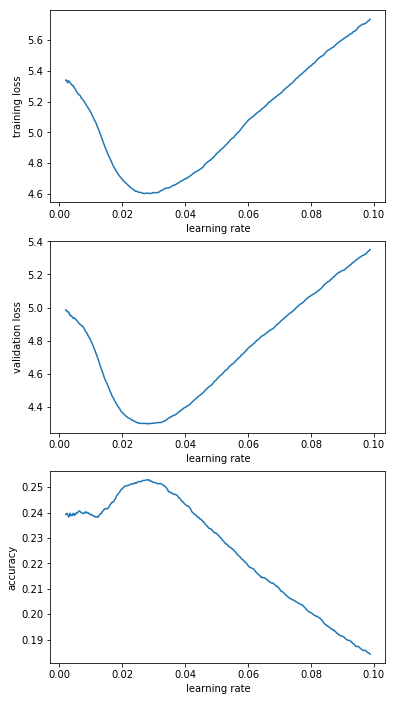

In [49]:
learner.sched.plot()

In [50]:
lrs = 0.02

In [51]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.296417   4.024642   0.277013  


[4.024642236897202, 0.27701257975375065]

In [52]:
learner.save('lm_last_ft')

In [53]:
learner.load('lm_last_ft')

In [54]:
learner.unfreeze()

In [57]:
learner.lr_find2(end_lr=0.002, wds=wd, num_it=500, linear=True)

 26%|█████████████████▎                                                  | 500/1959 [02:35<06:34,  3.70it/s, loss=4.25]

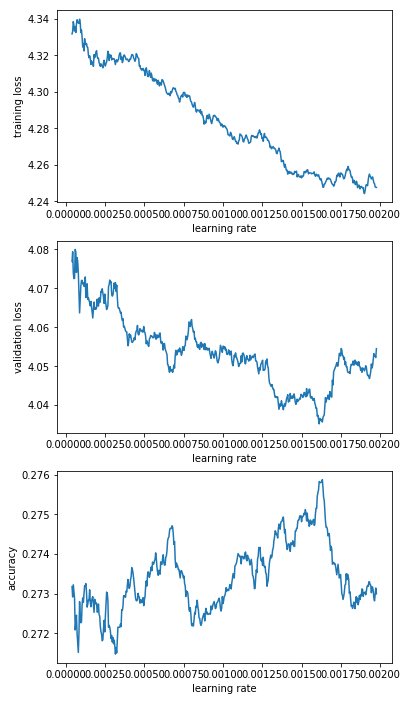

In [58]:
learner.sched.plot()

In [59]:
lrs = 0.00157

In [60]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.182033   3.998304   0.278956  
    1      4.137898   4.001905   0.278752                                                                              
    2      4.094177   3.998422   0.279228                                                                              
    3      4.062867   3.995618   0.279659                                                                              
    4      4.030664   3.992558   0.280252                                                                              
    5      4.004497   3.989565   0.280733                                                                              
    6      4.02783    3.985162   0.281313                                                                              
    7      3.96104    3.98188    0.281848                                                                           

[3.9781042650097707, 0.2824758106812102]

In [61]:
learner.save("lm1")

In [62]:
learner.save_encoder("lm1_enc")

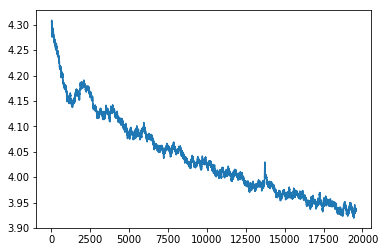

In [63]:
learner.sched.plot_loss()

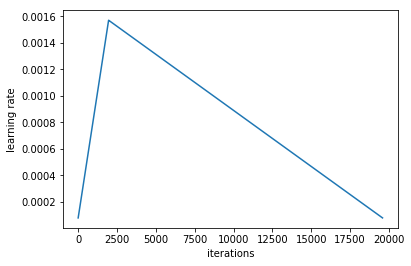

In [64]:
learner.sched.plot_lr()

In [65]:
df_trn = pd.read_csv(CLAS_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/"tst.csv", header=None, chunksize=chunksize)

In [66]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tol_tst, tst_labels = get_all(df_tst, 1)

0
1
2
3
4
5
6
0
0


In [67]:
(CLAS_PATH/"tmp").mkdir(exist_ok=True)

np.save(CLAS_PATH/"tmp"/"tok_trn.npy", tok_trn)
np.save(CLAS_PATH/"tmp"/"tok_val.npy", tok_val)
np.save(CLAS_PATH/"tmp"/"tok_tst.npy", tok_tst)

np.save(CLAS_PATH/"tmp"/"trn_labels.npy", trn_labels)
np.save(CLAS_PATH/"tmp"/"val_labels.npy", val_labels)
np.save(CLAS_PATH/"tmp"/"tst_labels.npy", tst_labels)

In [68]:
#necessary
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/"tmp"/"tok_tst.npy")

In [69]:
#Necessary
itos = pickle.load((LM_PATH/"tmp"/"itos.pkl").open("rb"))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

19321

In [70]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [71]:
np.save(CLAS_PATH/"tmp"/"trn_ids.npy", trn_clas)
np.save(CLAS_PATH/"tmp"/"val_ids.npy", val_clas)
np.save(CLAS_PATH/"tmp"/"tst_ids.npy", tst_clas)

## Classifier

In [72]:
#Necessary
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
tst_clas = np.load(CLAS_PATH/"tmp"/"tst_ids.npy")

In [73]:
#Necessary
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
tst_labels = np.squeeze(np.load(CLAS_PATH/"tmp"/"tst_labels.npy"))

In [74]:
#Necessary
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 100

In [75]:
#Necessary
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
tst_labels -= min_lbl
c=int(trn_labels.max())+1

In [76]:
#Necessary
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
tst_ds = TextDataset(tst_clas, tst_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))  #sorts dataset by length to reduce too strongly padded tensors
tst_samp = SortSampler(tst_clas, key=lambda x: len(tst_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, tst_dl)

In [77]:
#Necessary
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1

In [78]:
#Necessary
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                       layers=[em_sz*3, 50,c], drops=[dps[4], 0.2],
                      dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
#check dropout layers

In [79]:
#Necessary
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]
loss_weights = torch.FloatTensor(rtd_avg_weights).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)

In [80]:
wd = 1e-7
learn.load_encoder("lm1_enc")

In [81]:
learn.unfreeze()

  4%|██▌                                                               | 499/12800 [00:44<16:21, 12.53it/s, loss=0.523]

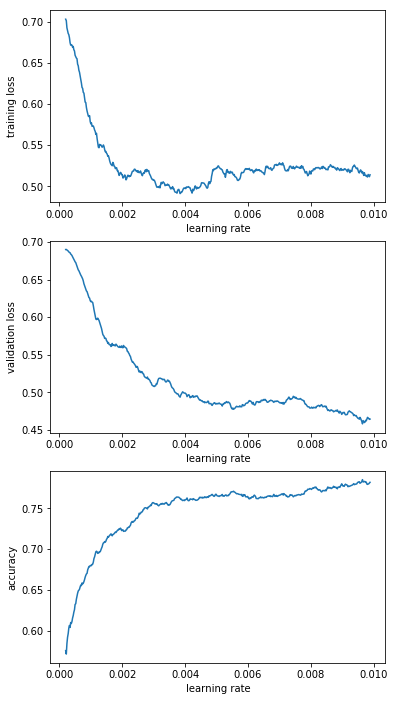

In [82]:
learn.lr_find2(end_lr=1e-2, wds=wd, num_it=500, linear=True)
learn.sched.plot()

In [83]:
lrs = 0.002

In [84]:
learn.freeze_to(-1)

In [85]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm1')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.457855   0.404778   0.81455   


[0.40477791065350177, 0.8145499796420336]

In [86]:
learn.save('clas_0')

In [87]:
learn.load('clas_0')

In [88]:
learn.freeze_to(-2)

In [89]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm2')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.432092   0.362644   0.84015   


[0.3626444448530674, 0.8401499786227942]

In [90]:
learn.save('clas_1')

In [106]:
learn.load('clas_1')

In [107]:
learn.unfreeze()

  4%|██▌                                                               | 500/12800 [00:43<15:59, 12.82it/s, loss=0.434]

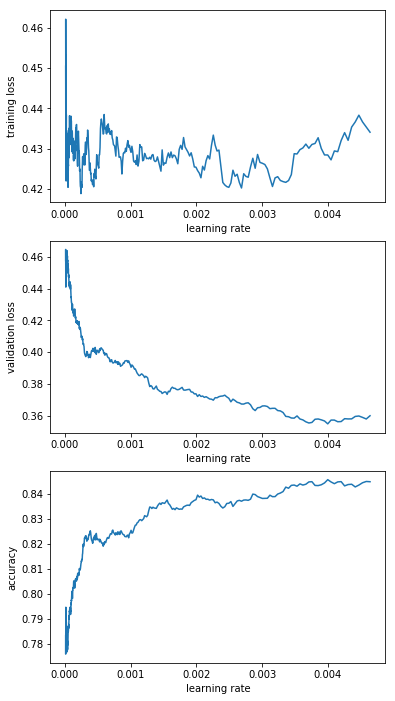

In [113]:
learn.lr_find2(end_lr=5e-3, num_it=500, wds=wd)
learn.sched.plot()

In [96]:
lrs = 0.0004

In [97]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=10, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_classifier')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.40635    0.348478   0.846737  
    1      0.407358   0.340745   0.850125                                                                              
    2      0.381314   0.337926   0.853112                                                                              
    3      0.385243   0.340618   0.853175                                                                              
    4      0.365271   0.340075   0.8537                                                                                
    5      0.38519    0.338614   0.854675                                                                              
    6      0.35251    0.342367   0.8546                                                                                
    7      0.336857   0.347701   0.853587                                                                           

[0.3561835040897131, 0.85339998036623]

In [110]:
lrs = 0.004

In [114]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_classifier')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.450207   0.388005   0.827112  


[0.3880045639909804, 0.8271124791353941]

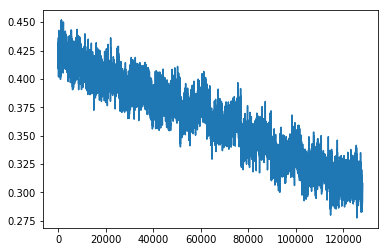

In [98]:
learn.sched.plot_loss()

In [99]:
learn.save('clas_2')

In [115]:
learn.load("clas_2")

In [116]:
val_lbls = np.load(CLAS_PATH/'tmp'/'val_labels.npy').flatten()
val_lbls_sampled = val_lbls[list(val_samp)]
predictions = np.argmax(learn.predict(), axis=1)
acc = (val_lbls_sampled == predictions).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1]
print(confusion_matrix(val_lbls_sampled, predictions, labels=clas_labels))
print("F-Score: ", f1_score(val_lbls_sampled, predictions, average="weighted"))
print("Sem-eval F-Score: ", f1_score(val_lbls_sampled, predictions, labels=[0,1], average="micro"))


print(classification_report(val_lbls_sampled, predictions))


Accuracy = 0.8534 , 
Confusion Matrix =
[[34306  5802]
 [ 5926 33966]]
F-Score:  0.8533990342550561
Sem-eval F-Score:  0.8534
             precision    recall  f1-score   support

          0       0.85      0.86      0.85     40108
          1       0.85      0.85      0.85     39892

avg / total       0.85      0.85      0.85     80000



In [117]:
tst_lbls_sampled = np.load(CLAS_PATH/'tmp'/'tst_labels.npy').flatten()
#tst_lbls_sampled = tst_lbls[list(tst_samp)]
predictions = np.argmax(learn.predict(True), axis=1)
acc = (tst_lbls_sampled == predictions).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1]
print(confusion_matrix(tst_lbls_sampled, predictions, labels=clas_labels))
print("F-Score: ", f1_score(tst_lbls_sampled, predictions, average="weighted"))
print("Sem-eval F-Score: ", f1_score(tst_lbls_sampled, predictions, labels=[0,1], average="micro"))


print(classification_report(tst_lbls_sampled, predictions))

Accuracy = 0.854325 , 
Confusion Matrix =
[[34775  5333]
 [ 6321 33571]]
F-Score:  0.8542979176177101
Sem-eval F-Score:  0.854325
             precision    recall  f1-score   support

          0       0.85      0.87      0.86     40108
          1       0.86      0.84      0.85     39892

avg / total       0.85      0.85      0.85     80000



## Submission

### Classifier weight tuning

In [118]:
x = [1,1] #[0.3,0.5,1.5,1]
rtd_avg_weights_clas = [x[i]/value for i, value in enumerate(rtd_avg_weights)]
rtd_avg_weights_clas

[1.0, 0.9954478845134539]

In [119]:
preds = learn.predict(True)*rtd_avg_weights_clas
preds = np.argmax(preds, axis=1)
preds[:30], predictions[:30]

(array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int64),
 array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int64))

In [120]:
tst_lbls_sampled = np.load(CLAS_PATH/'tmp'/'tst_labels.npy').flatten()
#tst_lbls_sampled = tst_lbls[list(tst_samp)]
predictions = np.argmax(learn.predict(True), axis=1)
acc = (tst_lbls_sampled == preds).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1]
print(confusion_matrix(tst_lbls_sampled, preds, labels=clas_labels))
print("F-Score: ", f1_score(tst_lbls_sampled, preds, average="weighted"))
print("Sem-eval F-Score: ", f1_score(tst_lbls_sampled, preds, labels=[0,1], average="micro"))


print(classification_report(tst_lbls_sampled, preds))

Accuracy = 0.8543 , 
Confusion Matrix =
[[34772  5336]
 [ 6320 33572]]
F-Score:  0.8542731123002675
Sem-eval F-Score:  0.8543
             precision    recall  f1-score   support

          0       0.85      0.87      0.86     40108
          1       0.86      0.84      0.85     39892

avg / total       0.85      0.85      0.85     80000



In [129]:
x = np.unique(preds, return_counts=True)
y = np.unique(predictions, return_counts=True)

x[1]/[[np.sum(x[1])]*len(x[1])], y[1]/[[np.sum(y[1])]*len(y[1])]

(array([[0.53333, 0.46668]]), array([[0.53336, 0.46664]]))

### Create output

In [145]:
def create_output():
    output = []
    output.append(["id","turn1", "turn2", "turn3", "label"])
    preds = learn.predict(True)*rtd_avg_weights_clas
    """for i, ele in enumerate(preds):
        if np.argmax(ele) == 3:
            preds[i][3] = -10"""
    predictions = np.argmax(preds, axis=1) #(True = Testset)
    
    
    for i, text in enumerate(tst_texts):
        turns = text.split("eot")
        output.append([str(i),turns[0].strip(), turns[1].strip(), turns[2].strip(), CLASSES[predictions[i]]])
    return output

In [146]:
def write_sample():
    outputs = create_output()
    with open("test.txt", "w", encoding="utf-8") as writer:
        for output_set in outputs:
            line = "\t".join(output_set)
            writer.write(line+"\n")
write_sample()

IndexError: list index out of range

In [ ]:
np.exp(3.91)